<blockquote>
    <h1>Exercise 6.8</h1>
    <p>In this exercise, we will generate simulated data, and will then use this data to perform best subset selection.</p>
    <ol>
        <li>Use the <code>rnorm()</code> function to generate a predictor $X$ of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.</li>
        <li>Generate a response vector $Y$ of length $n = 100$ according to the model
            $$
                Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon \,,
            $$
            where $\beta_0$, $\beta_1$, $\beta_2$ and $\beta_3$ are constants of your choice.
        </li>
        <li>Use the <code>regsubsets()</code> function to perform best subset selection in order to choose the best model containing the predictors $X, X^2, \ldots, X^{10}$. What is the best model obtained according to $C_p$, $\mathrm{BIC}$, and adjusted $R^2$? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the <code>data.frame()</code> function to create a single data set containing both $X$ and $Y$.</li>
        <li>Repeat 3, using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in 3?</li>
        <li>Now fit a lasso model to the simulated data, again using $X, X^2, \ldots, X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.</li>
        <li>Now generate a response vector $Y$ according to the model
            $$
            Y = \beta_0 + \beta_7 X^7 + \epsilon \,,
            $$
            and perform best subset selection and the lasso. Discuss the results obtained.
        </li>
    </ol>
</blockquote>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%run ../../customModules/usefulFunctions.ipynb
# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
import itertools
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeaveOneOut

In [2]:
def fit_linear_reg(df_X, df_Y):
    # Fit linear regression model and return RSS values
    model = sm.OLS(df_Y, df_X)
    fitted = model.fit()
    RSS = fitted.ssr
    BIC = fitted.bic
    R_sq_adj = fitted.rsquared_adj
    return RSS, BIC, R_sq_adj

<h3>Exercise 6.8.1</h3>
<blockquote>
    <i>Use the <code>rnorm()</code> function to generate a predictor $X$ of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.</i>
</blockquote>

In [3]:
np.random.seed(1)
n = 100
x = np.random.normal(size=n, loc=0, scale=1)
epsilon = np.random.normal(size=n, loc=0, scale=1)

<h3>Exercise 6.8.2</h3>
<blockquote>
    <i>
        Generate a response vector $Y$ of length $n = 100$ according to the model
        $$
            Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon \,,
        $$
        where $\beta_0$, $\beta_1$, $\beta_2$ and $\beta_3$ are constants of your choice.
    </i>
</blockquote>

In [4]:
b0, b1, b2, b3 = 2, 0.3, -1.5, 0.8
y = b0 + b1*x + b2*x**2 + b3*x**3 + epsilon

<h3>Exercise 6.8.3</h3>
<blockquote>
    <i>Use the <code>regsubsets()</code> function to perform best subset selection in order to choose the best model containing the predictors $X, X^2, \ldots, X^{10}$. What is the best model obtained according to $C_p$, $\mathrm{BIC}$, and adjusted $R^2$? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the <code>data.frame()</code> function to create a single data set containing both $X$ and $Y$.</i>
</blockquote>

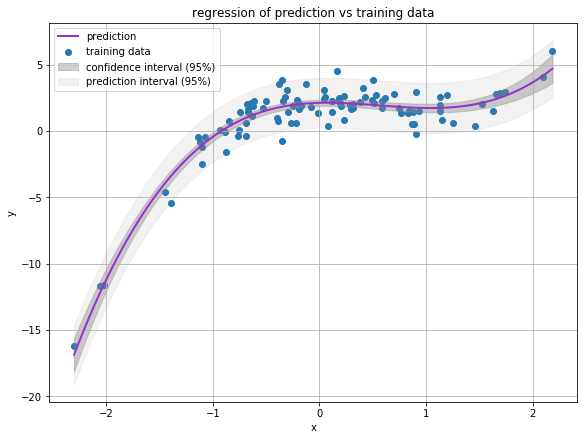

In [5]:
df_x = pd.DataFrame({'x': x})
for i in range(2, 11):
    key = 'x^' + str(i)
    df_x[key] = df_x['x']**i

df_x.insert(0, 'Intercept', 1)
df_y = pd.DataFrame({'y': y})

model = sm.OLS(df_y, df_x[['Intercept', 'x', 'x^2', 'x^3']])
fitted = model.fit()

polynomialMap = {
    'x': 1,
    'x^2': 2,
    'x^3': 3,
}
createPolynomialLinearRegressionPlot(df_x[['Intercept', 'x', 'x^2', 'x^3']], df_y, fitted_model=fitted, 
                                     height=6, width=8, polynomialMap=polynomialMap)

In [6]:
RSS, BIC, R_sq_adj = fit_linear_reg(df_x[['Intercept']], df_y)
best_submodels = {
    0: (['Intercept'], RSS, BIC, R_sq_adj),  # null model
}

p = df_x.shape[1] - 1
features_lst = df_x.columns.tolist()[1:] # excluding intercept; necessary for all combinations
for k in range(1, p + 1):
    RSS_min_subset = float('+inf')
    BIC_best_subset = None
    R_sq_adj_best_subset = None
    descriptiveColumns_best_subset = None
    #Looping over all possible combinations: from p choose k
    for descriptiveColumns in itertools.combinations(features_lst, k):
        descriptiveColumns = ['Intercept'] + list(descriptiveColumns)
        RSS, BIC, R_sq_adj = fit_linear_reg(df_x[descriptiveColumns], df_y)
        if RSS < RSS_min_subset:
            RSS_min_subset = RSS
            BIC_best_subset = BIC
            R_sq_adj_best_subset = R_sq_adj
            descriptiveColumns_best_subset = descriptiveColumns
        
    best_submodels[k] = (descriptiveColumns_best_subset, RSS_min_subset, BIC_best_subset, R_sq_adj_best_subset)
    
    if k == p:
        assert k == len(features_lst), f'k = {k} and features_lst = {features_lst}'
        sigma_squared_est = (1/(n - p -1)) * RSS  # Typically this is estimated using the full model containing all predictors

for k, (descriptiveColumns, RSS, BIC, R_sq_adj) in best_submodels.items():
    C_p = (1/n) * (RSS + 2*k*sigma_squared_est)
    best_submodels[k] = (descriptiveColumns, RSS, C_p, BIC, R_sq_adj)
    
df_best_submodels = pd.DataFrame(best_submodels, index=['variables', 'RSS', 'C_p', 'BIC', 'adj R^2']).T
df_best_submodels.index.name = 'number of predictors'
df_best_submodels

,variables,RSS,C_p,BIC,adj R^2
number of predictors,,,,,
0,[Intercept],900.992,9.00992,508.226,0
1,"[Intercept, x^5]",341.619,3.43338,415.851,0.616972
2,"[Intercept, x^2, x^3]",85.8861,0.893242,282.388,0.902711
3,"[Intercept, x^2, x^3, x^6]",80.9126,0.860698,281.028,0.90739
4,"[Intercept, x, x^2, x^3, x^6]",79.8002,0.866765,284.249,0.907701
5,"[Intercept, x, x^2, x^3, x^8, x^10]",79.4467,0.88042,288.41,0.907133
6,"[Intercept, x, x^2, x^5, x^7, x^8, x^9]",78.075,0.883893,291.274,0.907755
7,"[Intercept, x, x^2, x^3, x^5, x^7, x^9, x^10]",77.5352,0.895686,295.185,0.907397
8,"[Intercept, x, x^4, x^5, x^6, x^7, x^8, x^9, x...",76.9679,0.907204,299.056,0.907064


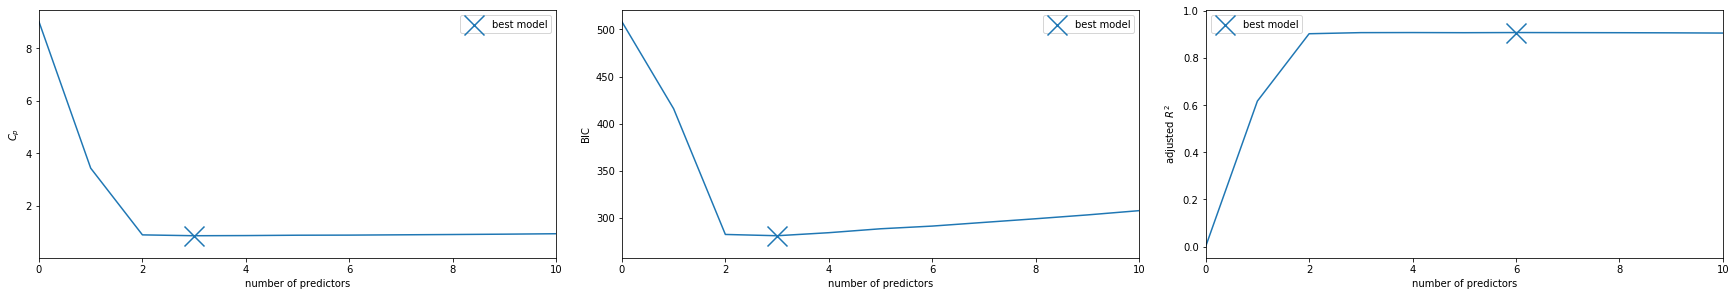

In [7]:
# df_best_submodels
df_best_C_p = df_best_submodels[df_best_submodels['C_p'] == df_best_submodels['C_p'].min()]
df_best_BIC = df_best_submodels[df_best_submodels['BIC'] == df_best_submodels['BIC'].min()]
df_best_R_sq_adj = df_best_submodels[df_best_submodels['adj R^2'] == df_best_submodels['adj R^2'].max()]

numberOfSubplots = 3
fig, [ax1, ax2, ax3] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_best_submodels['C_p'].plot(ax=ax1, label='')
_ = ax1.scatter(x=df_best_C_p.index[0], y=df_best_C_p['C_p'].iloc[0], marker='x', s=400, label='best model')
_ = ax1.set_ylabel(r'$C_p$')
_ = ax1.legend()

_ = df_best_submodels['BIC'].plot(ax=ax2, label='')
_ = ax2.scatter(x=df_best_BIC.index[0], y=df_best_BIC['BIC'].iloc[0], marker='x', s=400, label='best model')
_ = ax2.set_ylabel(r'$\mathrm{BIC}$')
_ = ax2.legend()

_ = df_best_submodels['adj R^2'].plot(ax=ax3, label='')
_ = ax3.scatter(x=df_best_R_sq_adj.index[0], y=df_best_R_sq_adj['adj R^2'].iloc[0], marker='x', s=400, label='best model')
_ = ax3.set_ylabel(r'adjusted $R^2$')
_ = ax3.legend()

<h3>Exercise 6.8.4</h3>
<blockquote>
    <i>Repeat 3, using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in 3?</i>
</blockquote>

,variables,RSS,C_p,BIC,adj R^2
number of predictors,,,,,
0,[Intercept],900.992,9.00992,508.226,0
1,"[Intercept, x^5]",341.619,3.43338,415.851,0.616972
2,"[Intercept, x^2, x^5]",131.899,1.35337,325.29,0.850588
3,"[Intercept, x^2, x^3, x^5]",85.2662,0.904234,286.269,0.902407
4,"[Intercept, x^2, x^3, x^5, x^6]",80.2795,0.871557,284.848,0.907147
5,"[Intercept, x, x^2, x^3, x^5, x^6]",79.7996,0.883949,288.854,0.90672
6,"[Intercept, x, x^2, x^3, x^5, x^6, x^10]",79.4952,0.898095,293.077,0.906077
7,"[Intercept, x, x^2, x^3, x^4, x^5, x^6, x^10]",78.948,0.909815,296.991,0.90571
8,"[Intercept, x, x^2, x^3, x^4, x^5, x^6, x^8, x...",78.2001,0.919526,300.644,0.905576


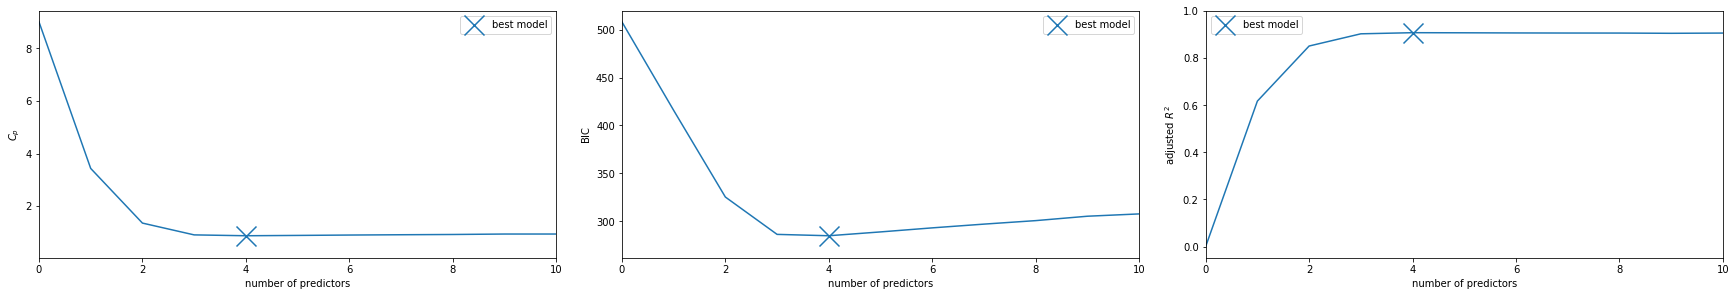

In [8]:
# forward stepwise selection
RSS, BIC, R_sq_adj = fit_linear_reg(df_x[['Intercept']], df_y)
best_submodels = {
    0: (['Intercept'], RSS, BIC, R_sq_adj),  # null model
}
best_features_set = {'Intercept'}

for k in range(1, p+1):
    RSS_min_subset = float('+inf')
    BIC_best_subset = None
    R_sq_adj_best_subset = None
    descriptiveColumns_best_subset = None
    for descriptiveColumns in itertools.combinations(features_lst, k):
        descriptiveColumns = ['Intercept'] + list(descriptiveColumns) 
        if not best_features_set.issubset(set(descriptiveColumns)):
            continue
            
        RSS, BIC, R_sq_adj = fit_linear_reg(df_x[descriptiveColumns], df_y)
        if RSS < RSS_min_subset:
            RSS_min_subset = RSS
            BIC_best_subset = BIC
            R_sq_adj_best_subset = R_sq_adj
            descriptiveColumns_best_subset = descriptiveColumns
          
    best_submodels[k] = (descriptiveColumns_best_subset, RSS_min_subset, BIC_best_subset, R_sq_adj_best_subset)
    
    difference_ = set(descriptiveColumns_best_subset) - best_features_set # Return a set that contains the items that only exist in set set(descriptiveColumns_best_subset), and not in set best_features_set
    assert len(difference_) == 1, f'difference_ = {difference_}'
    best_feature = list(difference_)[0]
    best_features_set.add(best_feature)
    
    if k == p:
        assert k == len(features_lst), f'k = {k} and features_lst = {features_lst}'
        sigma_squared_est = (1/(n - p - 1)) * RSS  # Typically this is estimated using the full model containing all predictors
        
        
for k, (descriptiveColumns, RSS, BIC, R_sq_adj) in best_submodels.items():
    C_p = (1/n) * (RSS + 2*k*sigma_squared_est)
    best_submodels[k] = (descriptiveColumns, RSS, C_p, BIC, R_sq_adj)
    
df_best_submodels = pd.DataFrame(best_submodels, index=['variables', 'RSS', 'C_p', 'BIC', 'adj R^2']).T
df_best_submodels.index.name = 'number of predictors'
df_best_submodels

# df_best_submodels
df_best_C_p = df_best_submodels[df_best_submodels['C_p'] == df_best_submodels['C_p'].min()]
df_best_BIC = df_best_submodels[df_best_submodels['BIC'] == df_best_submodels['BIC'].min()]
df_best_R_sq_adj = df_best_submodels[df_best_submodels['adj R^2'] == df_best_submodels['adj R^2'].max()]

numberOfSubplots = 3
fig, [ax1, ax2, ax3] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_best_submodels['C_p'].plot(ax=ax1, label='')
_ = ax1.scatter(x=df_best_C_p.index[0], y=df_best_C_p['C_p'].iloc[0], marker='x', s=400, label='best model')
_ = ax1.set_ylabel(r'$C_p$')
_ = ax1.legend()

_ = df_best_submodels['BIC'].plot(ax=ax2, label='')
_ = ax2.scatter(x=df_best_BIC.index[0], y=df_best_BIC['BIC'].iloc[0], marker='x', s=400, label='best model')
_ = ax2.set_ylabel(r'$\mathrm{BIC}$')
_ = ax2.legend()

_ = df_best_submodels['adj R^2'].plot(ax=ax3, label='')
_ = ax3.scatter(x=df_best_R_sq_adj.index[0], y=df_best_R_sq_adj['adj R^2'].iloc[0], marker='x', s=400, label='best model')
_ = ax3.set_ylabel(r'adjusted $R^2$')
_ = ax3.legend()

,variables,RSS,C_p,BIC,adj R^2
number of predictors,,,,,
10,"[Intercept, x, x^2, x^3, x^4, x^5, x^6, x^7, x...",76.4981,0.936887,307.654,0.905556
9,"[Intercept, x, x^3, x^4, x^5, x^6, x^7, x^8, x...",76.5585,0.9203,303.128,0.906532
8,"[Intercept, x, x^4, x^5, x^6, x^7, x^8, x^9, x...",76.9679,0.907204,299.056,0.907064
7,"[Intercept, x, x^4, x^5, x^6, x^7, x^8, x^9]",78.8559,0.908894,296.874,0.90582
6,"[Intercept, x, x^4, x^5, x^6, x^7, x^8]",79.8573,0.901717,293.531,0.905649
5,"[Intercept, x^4, x^5, x^6, x^7, x^8]",89.0574,0.976527,299.83,0.895899
4,"[Intercept, x^4, x^5, x^6, x^7]",109.92,1.16796,316.272,0.872865
3,"[Intercept, x^4, x^5, x^6]",140.238,1.45395,336.025,0.839488
2,"[Intercept, x^4, x^5]",170.767,1.74205,351.116,0.80656


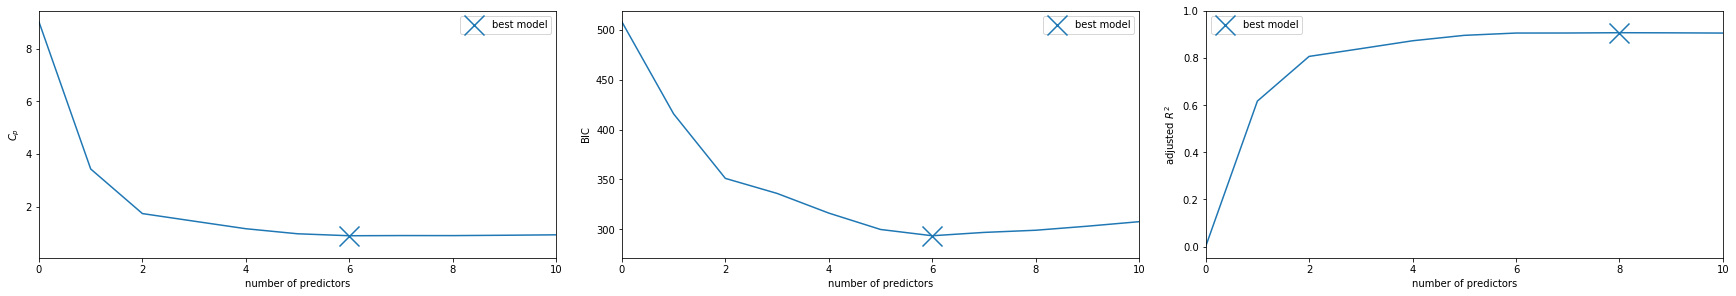

In [9]:
# backwards stepwise selection
RSS, BIC, R_sq_adj = fit_linear_reg(df_x[['Intercept'] + features_lst], df_y)
sigma_squared_est = (1/(n - p - 1)) * RSS
best_submodels = {
    p: (['Intercept'] + features_lst, RSS, BIC, R_sq_adj),  # full model
}
RSS, BIC, R_sq_adj = fit_linear_reg(df_x[['Intercept']], df_y)
best_submodels[0] = (['Intercept'], RSS, BIC, R_sq_adj)  # null model
best_features_set = set(['Intercept'] + features_lst)
worst_features_set = set()

for k in range(p - 1, 0, -1):
    RSS_min_subset = float('+inf')
    BIC_best_subset = None
    R_sq_adj_best_subset = None
    descriptiveColumns_best_subset = None
    for descriptiveColumns in itertools.combinations(features_lst, k):
        intersection = worst_features_set.intersection(descriptiveColumns)
        if len(intersection) != 0:
            continue
        
        descriptiveColumns = ['Intercept'] + list(descriptiveColumns)
        
        RSS, BIC, R_sq_adj = fit_linear_reg(df_x[descriptiveColumns], df_y)
        if RSS < RSS_min_subset:
            RSS_min_subset = RSS
            BIC_best_subset = BIC
            R_sq_adj_best_subset = R_sq_adj
            descriptiveColumns_best_subset = descriptiveColumns

    best_submodels[k] = (descriptiveColumns_best_subset, RSS_min_subset, BIC_best_subset, R_sq_adj_best_subset)

    difference_ = best_features_set - set(descriptiveColumns_best_subset)
    assert len(difference_) == 1, f'difference_ = {difference_}'
    worst_feature = list(difference_)[0]
    worst_features_set.add(worst_feature)
    best_features_set.remove(worst_feature)
    
for k, (descriptiveColumns, RSS, BIC, R_sq_adj) in best_submodels.items():
    C_p = (1/n) * (RSS + 2*k*sigma_squared_est)
    best_submodels[k] = (descriptiveColumns, RSS, C_p, BIC, R_sq_adj)
    
df_best_submodels = pd.DataFrame(best_submodels, index=['variables', 'RSS', 'C_p', 'BIC', 'adj R^2']).T.sort_index(ascending=False)
df_best_submodels.index.name = 'number of predictors'
df_best_submodels

# df_best_submodels
df_best_C_p = df_best_submodels[df_best_submodels['C_p'] == df_best_submodels['C_p'].min()]
df_best_BIC = df_best_submodels[df_best_submodels['BIC'] == df_best_submodels['BIC'].min()]
df_best_R_sq_adj = df_best_submodels[df_best_submodels['adj R^2'] == df_best_submodels['adj R^2'].max()]

numberOfSubplots = 3
fig, [ax1, ax2, ax3] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_best_submodels['C_p'].plot(ax=ax1, label='')
_ = ax1.scatter(x=df_best_C_p.index[0], y=df_best_C_p['C_p'].iloc[0], marker='x', s=400, label='best model')
_ = ax1.set_ylabel(r'$C_p$')
_ = ax1.legend()

_ = df_best_submodels['BIC'].plot(ax=ax2, label='')
_ = ax2.scatter(x=df_best_BIC.index[0], y=df_best_BIC['BIC'].iloc[0], marker='x', s=400, label='best model')
_ = ax2.set_ylabel(r'$\mathrm{BIC}$')
_ = ax2.legend()

_ = df_best_submodels['adj R^2'].plot(ax=ax3, label='')
_ = ax3.scatter(x=df_best_R_sq_adj.index[0], y=df_best_R_sq_adj['adj R^2'].iloc[0], marker='x', s=400, label='best model')
_ = ax3.set_ylabel(r'adjusted $R^2$')
_ = ax3.legend()

<h3>Exercise 6.8.5</h3>
<blockquote>
    <i>Now fit a lasso model to the simulated data, again using $X, X^2, \ldots, X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.</i>
</blockquote>

,Intercept,x,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10
0,0.0,0.104274,-1.533107,2.199351,-0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.025379,-1.424775,2.161298,-0.0,0.000000,-0.0,0.0,-0.0,0.0,-0.0
2,0.0,0.000000,-1.320313,2.079440,-0.0,0.000000,-0.0,0.0,-0.0,0.0,-0.0
3,0.0,0.000000,-1.217681,1.976808,-0.0,0.000000,-0.0,0.0,-0.0,0.0,-0.0
4,0.0,0.000000,-1.113647,1.856372,-0.0,0.018255,-0.0,0.0,-0.0,0.0,-0.0


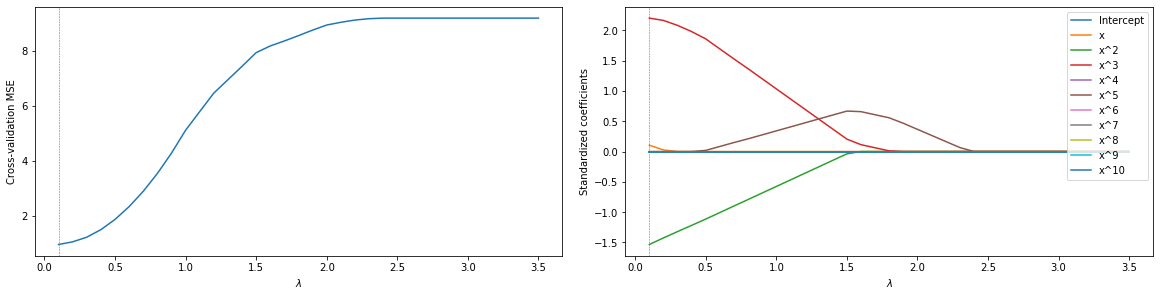

In [10]:
columns = df_x.columns
df_x_standardized = pd.DataFrame(preprocessing.scale(df_x), columns=columns)
df_x_standardized['Intercept'] = 1

loocv = LeaveOneOut() # leave-one-out cross-validation
stop = 3.5
num = 35
start = stop / num
lambda_arr = np.linspace(start=start, stop=stop, num=num)
mse_arr = np.empty(shape=lambda_arr.shape)
coef_arr = np.zeros(shape=(lambda_arr.shape[0], int(p+1)))
for index, lambda_ in enumerate(lambda_arr):
    MSE = 0
    for train_index, test_index in loocv.split(df_x_standardized):
        df_x_train, df_x_test = df_x_standardized.iloc[train_index], df_x_standardized.iloc[test_index]
        df_y_train, df_y_test = df_y.iloc[train_index], df_y.iloc[test_index]

        model = Lasso(alpha=lambda_)
        _ = model.fit(df_x_train, df_y_train)
        Y_pred = model.predict(df_x_test)
        MSE += (df_y_test.iloc[0, 0] - Y_pred[0])**2

    mse_arr[index] = MSE / n
    
    model = Lasso(alpha=lambda_)
    _ = model.fit(df_x_standardized, df_y) # fit with full data set
    coef_arr[index] = model.coef_

df_lasso_results = pd.DataFrame({
    'lambda': lambda_arr,
    'MSE': mse_arr,
})
lambda_min_mse = df_lasso_results.loc[df_lasso_results['MSE'].idxmin()].loc['lambda']

df_coef = pd.DataFrame(coef_arr, columns=columns)
df_coef.head()

numberOfSubplots = 2
fig, [ax1, ax2] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_lasso_results.plot(x='lambda', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel(r'$\lambda$')

for column in columns:
    _ = ax2.plot(df_lasso_results['lambda'], df_coef[column], label=column)
    _ = ax2.set_ylabel('Standardized coefficients')
    _ = ax2.set_xlabel(r'$\lambda$')
    
_ = ax2.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax2.legend(loc='upper right')
_ = ax1.set_xlim(ax2.get_xlim())

<h3>Exercise 6.8.6</h3>
<blockquote>
    <i>Now generate a response vector $Y$ according to the model
$$
Y = \beta_0 + \beta_7 X^7 + \epsilon \,,
$$
and perform best subset selection and the lasso. Discuss the results obtained.</i>
</blockquote>

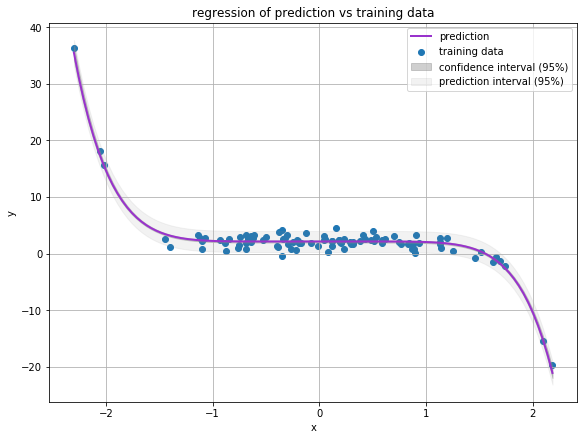

In [11]:
y = b0 - 0.1*x**7 + epsilon
df_y = pd.DataFrame({'y': y})

model = sm.OLS(df_y, df_x[['Intercept', 'x^7']])
fitted = model.fit()

polynomialMap = {
    'x^7': 7,
}

createPolynomialLinearRegressionPlot(df_x[['Intercept', 'x^7']], df_y, fitted_model=fitted, 
                                     height=6, width=8, polynomialMap=polynomialMap, 
                                     df_independent=pd.DataFrame({'x': x}))

,variables,RSS,C_p,BIC,adj R^2
number of predictors,,,,,
0,[Intercept],2527.75,25.2775,611.384,-2.22045e-16
1,"[Intercept, x^7]",85.1952,0.869142,276.976,0.965952
2,"[Intercept, x^7, x^10]",82.6358,0.86074,278.531,0.966634
3,"[Intercept, x^2, x^6, x^7]",80.1097,0.852669,280.031,0.967318
4,"[Intercept, x^4, x^6, x^7, x^8]",79.7107,0.86587,284.137,0.967138
5,"[Intercept, x^4, x^5, x^6, x^7, x^8]",78.8341,0.874294,287.636,0.967154
6,"[Intercept, x^3, x^4, x^5, x^6, x^7, x^9]",78.018,0.883324,291.201,0.967144
7,"[Intercept, x, x^3, x^4, x^5, x^6, x^7, x^9]",77.0908,0.891242,294.61,0.967182
8,"[Intercept, x, x^3, x^4, x^5, x^6, x^7, x^8, x^9]",77.0055,0.90758,299.105,0.966858


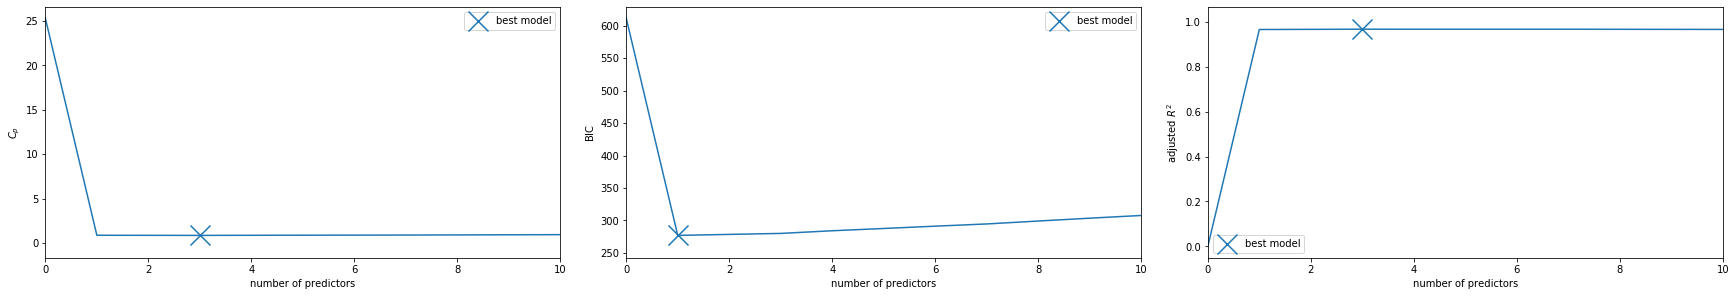

In [12]:
# subset selection
RSS, BIC, R_sq_adj = fit_linear_reg(df_x[['Intercept']], df_y)
best_submodels = {
    0: (['Intercept'], RSS, BIC, R_sq_adj),  # null model
}

p = df_x.shape[1] - 1
features_lst = df_x.columns.tolist()[1:] # excluding intercept; necessary for all combinations
for k in range(1, p + 1):
    RSS_min_subset = float('+inf')
    BIC_best_subset = None
    R_sq_adj_best_subset = None
    descriptiveColumns_best_subset = None
    #Looping over all possible combinations: from p choose k
    for descriptiveColumns in itertools.combinations(features_lst, k):
        descriptiveColumns = ['Intercept'] + list(descriptiveColumns)
        RSS, BIC, R_sq_adj = fit_linear_reg(df_x[descriptiveColumns], df_y)
        if RSS < RSS_min_subset:
            RSS_min_subset = RSS
            BIC_best_subset = BIC
            R_sq_adj_best_subset = R_sq_adj
            descriptiveColumns_best_subset = descriptiveColumns
        
    best_submodels[k] = (descriptiveColumns_best_subset, RSS_min_subset, BIC_best_subset, R_sq_adj_best_subset)
    
    if k == p:
        assert k == len(features_lst), f'k = {k} and features_lst = {features_lst}'
        sigma_squared_est = (1/(n - p -1)) * RSS  # Typically this is estimated using the full model containing all predictors

for k, (descriptiveColumns, RSS, BIC, R_sq_adj) in best_submodels.items():
    C_p = (1/n) * (RSS + 2*k*sigma_squared_est)
    best_submodels[k] = (descriptiveColumns, RSS, C_p, BIC, R_sq_adj)
    
df_best_submodels = pd.DataFrame(best_submodels, index=['variables', 'RSS', 'C_p', 'BIC', 'adj R^2']).T
df_best_submodels.index.name = 'number of predictors'
df_best_submodels

# df_best_submodels
df_best_C_p = df_best_submodels[df_best_submodels['C_p'] == df_best_submodels['C_p'].min()]
df_best_BIC = df_best_submodels[df_best_submodels['BIC'] == df_best_submodels['BIC'].min()]
df_best_R_sq_adj = df_best_submodels[df_best_submodels['adj R^2'] == df_best_submodels['adj R^2'].max()]

numberOfSubplots = 3
fig, [ax1, ax2, ax3] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_best_submodels['C_p'].plot(ax=ax1, label='')
_ = ax1.scatter(x=df_best_C_p.index[0], y=df_best_C_p['C_p'].iloc[0], marker='x', s=400, label='best model')
_ = ax1.set_ylabel(r'$C_p$')
_ = ax1.legend()

_ = df_best_submodels['BIC'].plot(ax=ax2, label='')
_ = ax2.scatter(x=df_best_BIC.index[0], y=df_best_BIC['BIC'].iloc[0], marker='x', s=400, label='best model')
_ = ax2.set_ylabel(r'$\mathrm{BIC}$')
_ = ax2.legend()

_ = df_best_submodels['adj R^2'].plot(ax=ax3, label='')
_ = ax3.scatter(x=df_best_R_sq_adj.index[0], y=df_best_R_sq_adj['adj R^2'].iloc[0], marker='x', s=400, label='best model')
_ = ax3.set_ylabel(r'adjusted $R^2$')
_ = ax3.legend()

,Intercept,x,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10
0,0.0,-0.0,-0.0,-0.0,0.0,-0.170032,0.0,-4.063305,0.0,-0.591018,0.071537
1,0.0,-0.0,0.0,-0.0,0.0,-0.000000,0.0,-4.193482,0.0,-0.551950,0.000000
2,0.0,-0.0,0.0,-0.0,0.0,-0.000000,0.0,-4.143780,0.0,-0.501326,0.000000
3,0.0,-0.0,0.0,-0.0,0.0,-0.000000,0.0,-4.093619,0.0,-0.451157,0.000000
4,0.0,-0.0,0.0,-0.0,0.0,-0.000000,0.0,-4.044121,0.0,-0.400331,0.000000


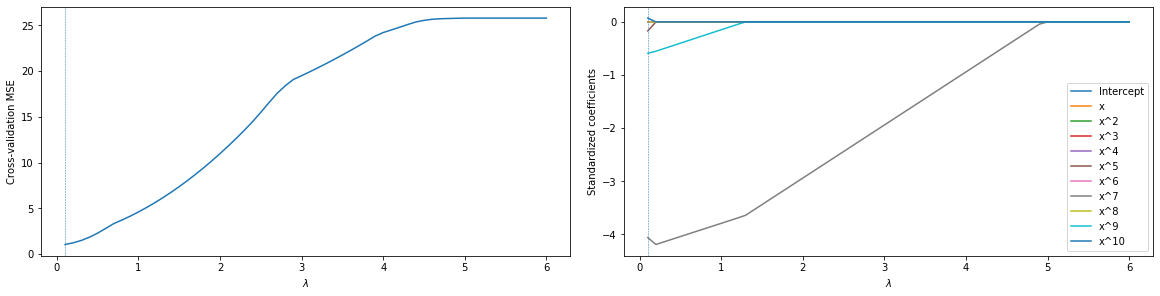

In [13]:
# lasso model
columns = df_x.columns
loocv = LeaveOneOut() # leave-one-out cross-validation
stop = 6
num = 60
start = stop / num
lambda_arr = np.linspace(start=start, stop=stop, num=num)
mse_arr = np.empty(shape=lambda_arr.shape)
coef_arr = np.zeros(shape=(lambda_arr.shape[0], int(p+1)))
for index, lambda_ in enumerate(lambda_arr):
    MSE = 0
    for train_index, test_index in loocv.split(df_x_standardized):
        df_x_train, df_x_test = df_x_standardized.iloc[train_index], df_x_standardized.iloc[test_index]
        df_y_train, df_y_test = df_y.iloc[train_index], df_y.iloc[test_index]

        model = Lasso(alpha=lambda_)
        _ = model.fit(df_x_train, df_y_train)
        Y_pred = model.predict(df_x_test)
        MSE += (df_y_test.iloc[0, 0] - Y_pred[0])**2

    mse_arr[index] = MSE / n
    
    model = Lasso(alpha=lambda_)
    _ = model.fit(df_x_standardized, df_y) # fit with full data set
    coef_arr[index] = model.coef_

df_lasso_results = pd.DataFrame({
    'lambda': lambda_arr,
    'MSE': mse_arr,
})
lambda_min_mse = df_lasso_results.loc[df_lasso_results['MSE'].idxmin()].loc['lambda']

df_coef = pd.DataFrame(coef_arr, columns=columns)
df_coef.head()

numberOfSubplots = 2
fig, [ax1, ax2] = plt.subplots(1, numberOfSubplots, constrained_layout=True, figsize=(8*numberOfSubplots, 4))

_ = df_lasso_results.plot(x='lambda', y='MSE', ax=ax1, legend=None)
_ = ax1.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.set_xlabel(r'$\lambda$')

for column in columns:
    _ = ax2.plot(df_lasso_results['lambda'], df_coef[column], label=column)
    _ = ax2.set_ylabel('Standardized coefficients')
    _ = ax2.set_xlabel(r'$\lambda$')
    
_ = ax2.axvline(x=lambda_min_mse, linestyle='dashed', linewidth=0.5)
_ = ax2.legend(loc='lower right')
_ = ax1.set_xlim(ax2.get_xlim())